# TC 5033
## Deep Learning
## Convolutional Neural Networks
<br>

#### Activity 2b: Building a CNN for CIFAR10 dataset with PyTorch
<br>

- Objective

    The main goal of this activity is to further your understanding of Convolutional Neural Networks (CNNs) by building one using PyTorch. You will apply this architecture to the famous CIFAR10 dataset, taking what you've learned from the guide code that replicated the Fully Connected model in PyTorch (Activity 2a).

- Instructions
    This activity requires submission in teams of 3 or 4 members. Submissions from smaller or larger teams will not be accepted unless prior approval has been granted (only due to exceptional circumstances). While teamwork is encouraged, each member is expected to contribute individually to the assignment. The final submission should feature the best arguments and solutions from each team member. Only one person per team needs to submit the completed work, but it is imperative that the names of all team members are listed in a Markdown cell at the very beginning of the notebook (either the first or second cell). Failure to include all team member names will result in the grade being awarded solely to the individual who submitted the assignment, with zero points given to other team members (no exceptions will be made to this rule).

    Understand the Guide Code: Review the guide code from Activity 2a that implemented a Fully Connected model in PyTorch. Note how PyTorch makes it easier to implement neural networks.

    Familiarize Yourself with CNNs: Take some time to understand their architecture and the rationale behind using convolutional layers.

    Prepare the Dataset: Use PyTorch's DataLoader to manage the dataset. Make sure the data is appropriately preprocessed for a CNN.

    Design the CNN Architecture: Create a new architecture that incorporates convolutional layers. Use PyTorch modules like nn.Conv2d, nn.MaxPool2d, and others to build your network.

    Training Loop and Backpropagation: Implement the training loop, leveraging PyTorch’s autograd for backpropagation. Keep track of relevant performance metrics.

    Analyze and Document: Use Markdown cells to explain your architectural decisions, performance results, and any challenges you faced. Compare this model with your previous Fully Connected model in terms of performance and efficiency.

- Evaluation Criteria

    - Understanding of CNN architecture and its application to the CIFAR10 dataset
    - Code Readability and Comments
    - Appropriateness and efficiency of the chosen CNN architecture
    - Correct implementation of Traning Loop and Accuracy Function
    - Model's performance metrics on the CIFAR10 dataset (at least 65% accuracy)
    - Quality of Markdown documentation

- Submission

Submit via Canvas your Jupyter Notebook with the CNN implemented in PyTorch. Your submission should include well-commented code and Markdown cells that provide a comprehensive view of your design decisions, performance metrics, and learnings.

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as datasets
import torchvision.transforms as T
import matplotlib.pyplot as plt

# load cifar 10 data
import _pickle as cPickle

In [2]:
torch.backends.mps.is_available()

True

In [3]:
DATA_PATH = './cifar-10-batches-py/'
NUM_TRAIN = 50000
NUM_VAL = 5000
NUM_TEST = 5000
MINIBATCH_SIZE = 64

transform_cifar = T.Compose([
                T.ToTensor(),
                T.Normalize([0.491, 0.482, 0.447], [0.247, 0.243, 0.261])
            ])

# Train dataset
cifar10_train = datasets.CIFAR10(DATA_PATH, train=True, download=True,
                             transform=transform_cifar)
train_loader = DataLoader(cifar10_train, batch_size=MINIBATCH_SIZE, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))
#Validation set
cifar10_val = datasets.CIFAR10(DATA_PATH, train=False, download=True,
                           transform=transform_cifar)
val_loader = DataLoader(cifar10_val, batch_size=MINIBATCH_SIZE, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_VAL)))
#Test set
cifar10_test = datasets.CIFAR10(DATA_PATH, train=False, download=True, 
                            transform=transform_cifar)
test_loader = DataLoader(cifar10_test, batch_size=MINIBATCH_SIZE,
                        sampler=sampler.SubsetRandomSampler(range(NUM_VAL, len(cifar10_test))))

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [116]:
cifar10_train

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./cifar-10-batches-py/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.491, 0.482, 0.447], std=[0.247, 0.243, 0.261])
           )

In [117]:
train_loader.batch_size

64

In [ ]:
for i, (x, y) in enumerate(train_loader):
    print(x, y)

In [4]:
if torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')
print(device)

mps


La imagen muestreada representa un: horse


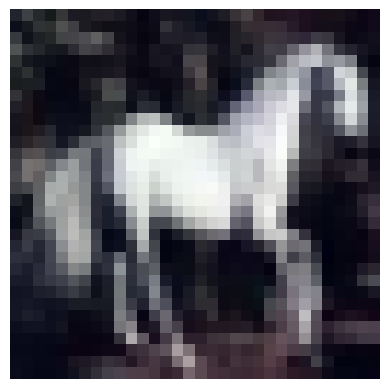

In [119]:
classes = test_loader.dataset.classes
def plot_figure(image):
    plt.imshow(np.transpose(image,(1,2,0)))
    plt.axis('off')
    plt.show()

rnd_sample_idx = np.random.randint(len(test_loader))
print(f'La imagen muestreada representa un: {classes[test_loader.dataset[rnd_sample_idx][1]]}')
image = test_loader.dataset[rnd_sample_idx][0]
image = (image - image.min()) / (image.max() -image.min() )
plot_figure(image)


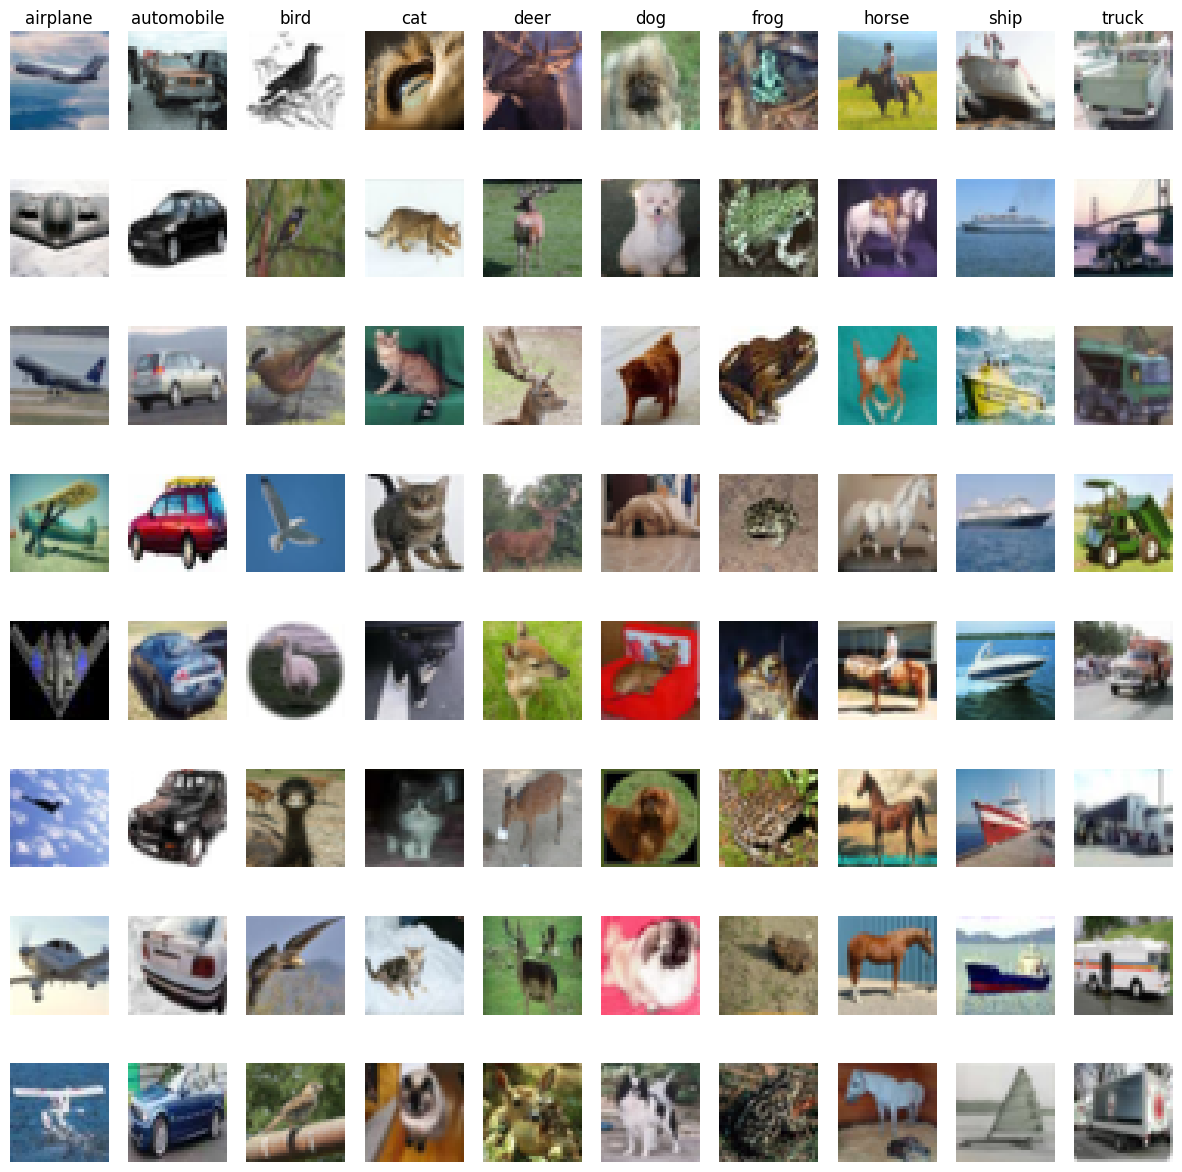

In [120]:
def plot_cifar10_grid():
    classes = test_loader.dataset.classes
    total_samples = 8
    plt.figure(figsize=(15,15))
    for label, sample in enumerate(classes):
        class_idxs = np.flatnonzero(label == np.array(test_loader.dataset.targets))
        sample_idxs = np.random.choice(class_idxs, total_samples, replace = False)
        for i, idx in enumerate(sample_idxs):
            plt_idx = i*len(classes) + label + 1
            plt.subplot(total_samples, len(classes), plt_idx)
            plt.imshow(test_loader.dataset.data[idx])
            plt.axis('off')
            
            if i == 0: plt.title(sample)
    plt.show()

plot_cifar10_grid() 

### Calcular accuracy


In [5]:
def accuracy(model, loader):
    num_correct = 0
    num_total = 0
    cost = 0
    model.eval()
    model = model.to(device=device)
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=torch.float32)
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            cost += (F.cross_entropy(scores, y)).item()
            _, preds = scores.max(1)

            num_correct += (preds == y).sum()
            num_total += preds.size(0)

        return cost/len(loader), float(num_correct) / num_total

In [6]:
def train_model(model, optimiser, epochs=100):
    model = model.to(device=device)
    train_cost = 0.
    val_cost = 0.

    for epoch in range(epochs):
        train_correct_num = 0.
        train_total = 0.
        train_cost_acum = 0.

        for x, y in train_loader:
            model.train()
            x = x.to(device=device, dtype=torch.float32)
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            cost = F.cross_entropy(input=scores, target=y)

            optimiser.zero_grad()
            cost.backward()
            optimiser.step()

            train_correct_num += (torch.argmax(scores, dim=1) == y).sum()
            train_total += scores.size(0)
            train_cost_acum += cost.item()

        val_cost, val_acc = accuracy(model, val_loader)
        train_acc = float(train_correct_num) / train_total
        train_cost = train_cost_acum / len(train_loader)

        print(f'Epoch:{epoch}, train cost: {train_cost:.6f}, val cost: {val_cost:.6f},'
                      f' train acc: {train_acc:.4f}, val acc: {val_acc:4f},'
                      f' lr: {optimiser.param_groups[0]["lr"]:.6f}')

### Sequential CNN

In [25]:
conv1 = nn.Conv2d(3, 32, 3, 1)
conv2 = nn.Conv2d(32, 64, 3, 1)
conv3 = nn.Conv2d(128, 256, 3, 1)
pool = nn.MaxPool2d(2,2)
flat = nn.Flatten()
linear1 = nn.Linear(64*13*13, 1024)

sample_input = torch.randn(1, 3, 32, 32)

print(sample_input.shape)
x = conv1(sample_input)
print(x.shape)
x = pool(x)
print(x.shape)
x = conv2(x)
print(x.shape)
x = pool(x)
print(x.shape)
# x = pool(x)
# print(x.shape)
# x = conv3(x)
# print(x.shape)

torch.Size([1, 3, 32, 32])
torch.Size([1, 32, 30, 30])
torch.Size([1, 32, 15, 15])
torch.Size([1, 64, 13, 13])
torch.Size([1, 64, 6, 6])


In [7]:
# hyperparameters
num_epochs = 25
learning_rate = 0.0001

In [149]:
# setup model
# model = ConvolutionalNN().to(device)

model = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, padding=1),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=21632, out_features=1024),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(in_features=1024, out_features=10)
)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [26]:
model2 = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Dropout(p=0.5),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Dropout(p=0.25),
    nn.Flatten(),
    nn.Linear(in_features=4096, out_features=120),
    nn.ReLU(),
    nn.Linear(in_features=120, out_features=10)
)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=learning_rate, weight_decay=0.0001)

In [150]:
train_model(model, optimizer, num_epochs)

Epoch:0, train cost: 2.119987, val cost: 1.949163, train acc: 0.2471, val acc: 0.317400, lr: 0.001000
Epoch:1, train cost: 1.899247, val cost: 1.807901, train acc: 0.3263, val acc: 0.372800, lr: 0.001000
Epoch:2, train cost: 1.781037, val cost: 1.694298, train acc: 0.3682, val acc: 0.402200, lr: 0.001000
Epoch:3, train cost: 1.684754, val cost: 1.609413, train acc: 0.4031, val acc: 0.433200, lr: 0.001000
Epoch:4, train cost: 1.607358, val cost: 1.534570, train acc: 0.4305, val acc: 0.458200, lr: 0.001000
Epoch:5, train cost: 1.546893, val cost: 1.484476, train acc: 0.4510, val acc: 0.479200, lr: 0.001000
Epoch:6, train cost: 1.495642, val cost: 1.444927, train acc: 0.4687, val acc: 0.489200, lr: 0.001000
Epoch:7, train cost: 1.455352, val cost: 1.400252, train acc: 0.4823, val acc: 0.500000, lr: 0.001000
Epoch:8, train cost: 1.419161, val cost: 1.364203, train acc: 0.4966, val acc: 0.518600, lr: 0.001000
Epoch:9, train cost: 1.386691, val cost: 1.340227, train acc: 0.5084, val acc: 0.5

In [151]:
accuracy(model, test_loader)[1]*100

62.88

In [27]:
train_model(model2, optimizer, num_epochs)

Epoch:0, train cost: 1.774850, val cost: 1.515748, train acc: 0.3735, val acc: 0.477000, lr: 0.000100
Epoch:1, train cost: 1.453672, val cost: 1.345200, train acc: 0.4854, val acc: 0.527200, lr: 0.000100
Epoch:2, train cost: 1.342945, val cost: 1.263023, train acc: 0.5226, val acc: 0.559400, lr: 0.000100
Epoch:3, train cost: 1.280196, val cost: 1.223081, train acc: 0.5467, val acc: 0.577200, lr: 0.000100
Epoch:4, train cost: 1.227892, val cost: 1.166694, train acc: 0.5665, val acc: 0.597000, lr: 0.000100
Epoch:5, train cost: 1.191780, val cost: 1.135734, train acc: 0.5788, val acc: 0.619200, lr: 0.000100
Epoch:6, train cost: 1.150501, val cost: 1.089764, train acc: 0.5972, val acc: 0.630600, lr: 0.000100
Epoch:7, train cost: 1.116480, val cost: 1.049138, train acc: 0.6097, val acc: 0.645400, lr: 0.000100
Epoch:8, train cost: 1.082315, val cost: 1.047825, train acc: 0.6212, val acc: 0.640400, lr: 0.000100
Epoch:9, train cost: 1.053053, val cost: 1.001814, train acc: 0.6302, val acc: 0.6

In [28]:
accuracy(model2, test_loader)[1]*100

70.72